In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc as calculate_auc
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel
from aggmap import show

In [2]:
dfx = pd.read_excel('./CRC.xlsx', sheet_name='data')
dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)


feature_groups_df = pd.read_excel('./CRC.xlsx', sheet_name='feature_info')
feature_group_list = feature_groups_df.Group.tolist()

dfy_all = pd.read_excel('./CRC.xlsx', sheet_name='sample_info')
dfy = pd.get_dummies(dfy_all['Group'])



X = dfx.values.astype(float)
Y = dfy.values.astype(float)


In [3]:
mp = AggMap(dfx, metric = 'correlation')

2020-10-27 12:00:56,285 - INFO - [bidd-aggmap] - Calculating distance ...
2020-10-27 12:00:56,327 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 849/849 [00:01<00:00, 815.43it/s]


In [4]:
mp.fit(cluster_channels = 5, verbose = 0)

2020-10-27 12:01:10,033 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-10-27 12:01:14,999 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-10-27 12:01:16,428 - INFO - [bidd-aggmap] - Finished


In [5]:
mp.fmap_shape

(30, 29)

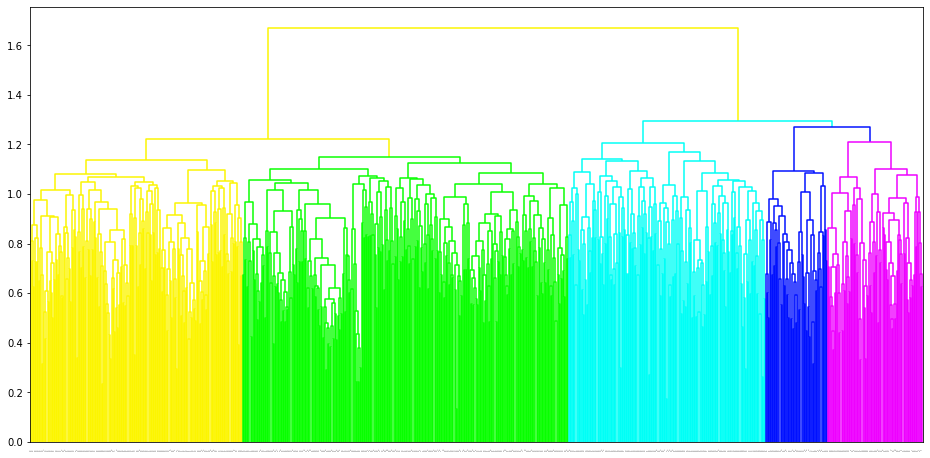

In [6]:
fig_tree = mp.plot_tree(add_leaf_labels = False, leaf_font_size = 1)
fig_tree.savefig('CRC.cluster5_tree.png', bbox_inches='tight', dpi=300)

In [7]:
mp.plot_scatter(enabled_data_labels = False, htmlname = 'CRC.C5_scatter',radius=5)

2020-10-27 12:01:50,406 - INFO - [bidd-aggmap] - generate file: ./CRC.C5_scatter_feature points_849_correlation_umap_scatter
2020-10-27 12:01:50,434 - INFO - [bidd-aggmap] - save html file to ./CRC.C5_scatter_feature points_849_correlation_umap_scatter


In [8]:
mp.plot_grid(enabled_data_labels = False, htmlname = 'CRC_C5.grid')

2020-10-27 12:01:50,453 - INFO - [bidd-aggmap] - generate file: ./CRC_C5.grid_feature points_849_correlation_umap_mp
2020-10-27 12:01:50,477 - INFO - [bidd-aggmap] - save html file to ./CRC_C5.grid_feature points_849_correlation_umap_mp


In [9]:
X_new = mp.batch_transform(X, scale_method= 'standard')

100%|##########| 575/575 [00:03<00:00, 182.02it/s]


In [10]:
X_new.shape

(575, 30, 29, 5)

In [13]:
dfy_all['Country'] = dfy_all.Country.map({'AUS':"AT", 'CHI':'CN', 'FRA':'FR', 'GER':'DE', 'USA':'US'})

In [33]:
idx2 = dfy_all.groupby(['Group', 'Country']).apply(lambda x:x.index.tolist())
idx2

Group  Country
CRC    AT         [171, 172, 173, 174, 175, 176, 177, 178, 179, ...
       CN         [223, 224, 225, 226, 227, 228, 229, 230, 232, ...
       DE         [457, 458, 459, 460, 461, 466, 467, 468, 469, ...
       FR         [3, 8, 14, 18, 19, 21, 22, 27, 30, 31, 32, 34,...
       US         [353, 354, 355, 356, 357, 360, 363, 365, 367, ...
CTR    AT         [114, 115, 116, 117, 118, 119, 120, 121, 122, ...
       CN         [231, 233, 241, 243, 247, 255, 270, 271, 272, ...
       DE         [455, 456, 462, 463, 464, 465, 471, 473, 474, ...
       FR         [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 1...
       US         [351, 352, 358, 359, 361, 362, 364, 366, 368, ...
dtype: object

In [ ]:
sns.reset_orig()

def plot2(rows, fname = './all_fmap.png'):

    n = 5
    fontsize = 12

    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(8,4), sharex = True, sharey = True)

    row_names = [', '.join(i) for i in rows]

    for row, row_ax in zip(rows, axes):
        pidx = idx.loc[row][:n]        
        for pid, ax in zip(pidx, row_ax):
            if 'CRC' in row:
                pid_name = 'CRC-%s' % pid
            else:
                pid_name = 'CTR-%s' % pid
            x = X_new[pid]
            #ax.imshow(X_new[pid].sum(axis=-1))
            vmin = x.min() + 2
            vmax = None
            show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=1, vmin = vmin, vmax = vmax)
            ax.set_xlabel(pid_name, fontsize = fontsize) 

    for ax, row in zip(axes[:,0], row_names):
        ax.set_ylabel(row, fontsize = fontsize)  

    fig.tight_layout()
    fig.savefig(fname, bbox_inches='tight', dpi=300) 

In [34]:
rows

[('US', 'CRC'), ('US', 'CTR')]

In [23]:
sns.reset_orig()

def plot(rows, fname = './Country1_fmp.png'):

    n = 8
    fontsize = 18

    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(13,4), sharex = True, sharey = True)

    row_names = [', '.join(i) for i in rows]

    for row, row_ax in zip(rows, axes):
        pidx = idx.loc[row][:n]        
        for pid, ax in zip(pidx, row_ax):
            if 'CRC' in row:
                pid_name = 'CRC-%s' % pid
            else:
                pid_name = 'CTR-%s' % pid
            x = X_new[pid]
            #ax.imshow(X_new[pid].sum(axis=-1))
            vmin = x.min() + 2
            vmax = None
            show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=1, vmin = vmin, vmax = vmax)
            ax.set_xlabel(pid_name, fontsize = fontsize) 

    for ax, row in zip(axes[:,0], row_names):
        ax.set_ylabel(row, fontsize = fontsize)  

    fig.tight_layout()
    fig.savefig(fname, bbox_inches='tight', dpi=300) 

In [24]:
x = X_new[1]

In [26]:
x.max(), x.min()

(4.861834233313737, -3.036348418355197)

## Country-1: AUS

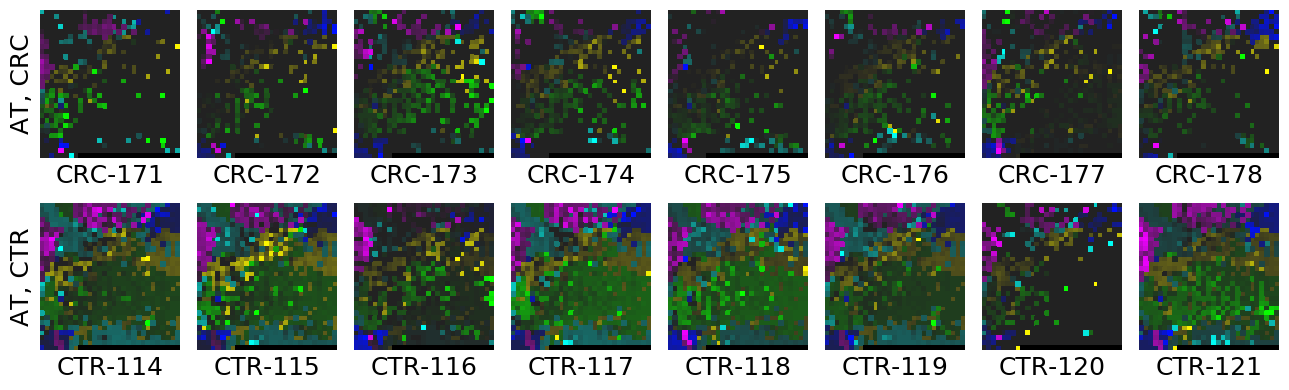

In [27]:
rows = idx.index.tolist()
rows = rows[:2]
plot(rows, fname = './Country1_fmp.png')

## Country-2 

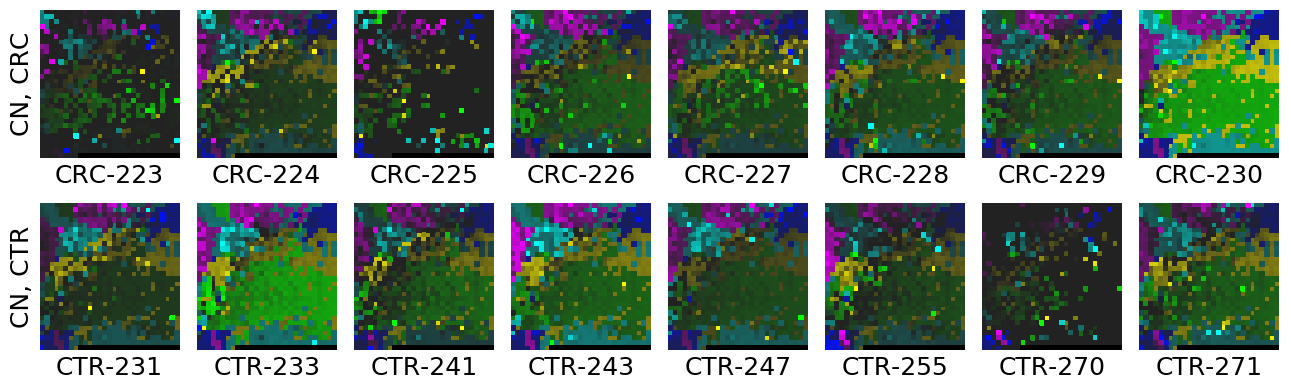

In [28]:
rows = idx.index.tolist()
rows = rows[2:4]
plot(rows, fname = './Country2_fmp.png')

## Country-3

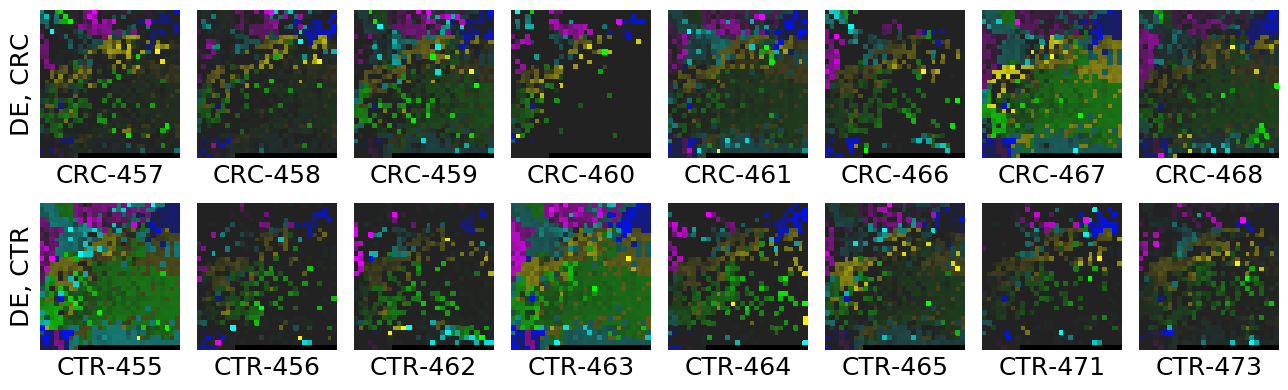

In [29]:
rows = idx.index.tolist()
rows = rows[4:6]
plot(rows, fname = './Country3_fmp.png')

## Country-4

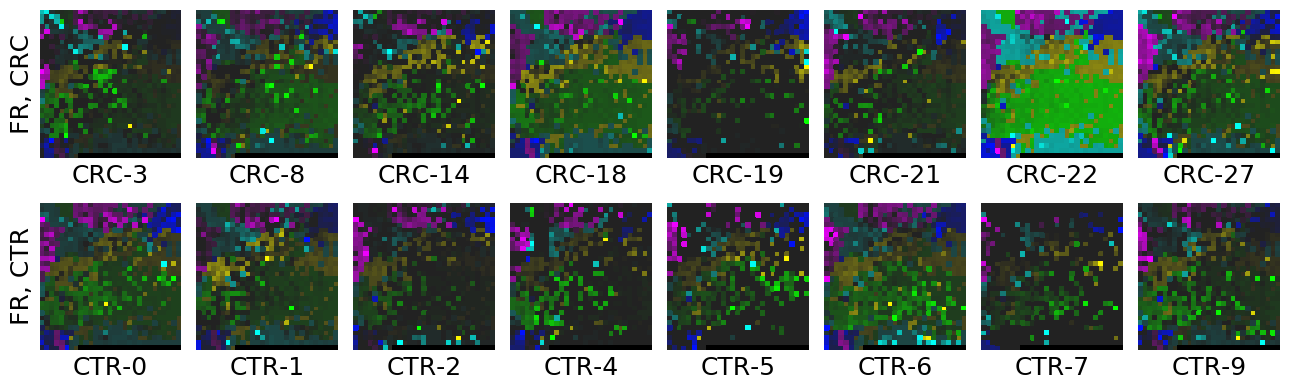

In [30]:
rows = idx.index.tolist()
rows = rows[6:8]
plot(rows, fname = './Country4_fmp.png')

## Country-5

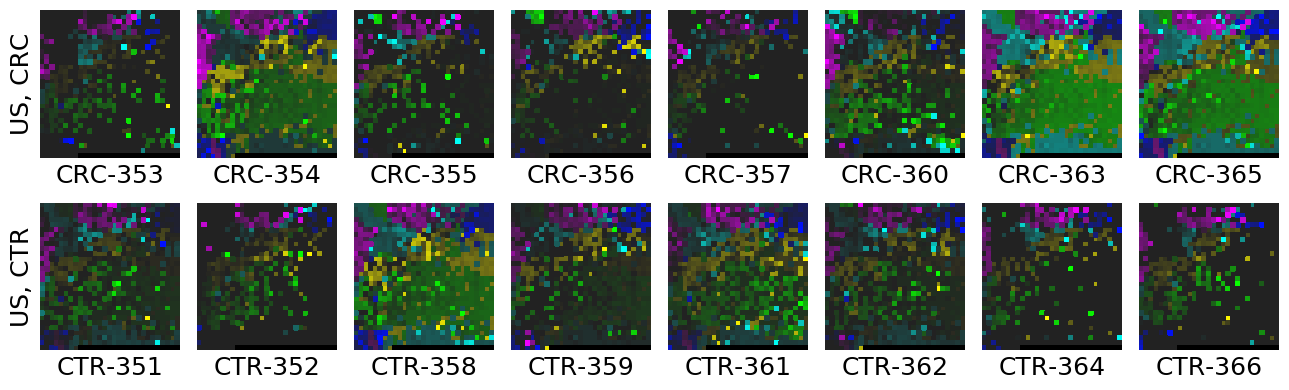

In [31]:
rows = idx.index.tolist()
rows = rows[8:10]
plot(rows, fname = './Country5_fmp.png')